In [1]:
import os
import nltk
import base64
from base64 import b64encode, b64decode
import uuid
from IPython.display import display, HTML
from unstructured.partition.pdf import partition_pdf
from operator import itemgetter
from pydantic import Field
from typing import List, TypedDict

from langchain_core.documents import Document
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_classic.retrievers import MultiVectorRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.stores import BaseStore
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.stores import InMemoryStore
from langchain_openai import ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma

In [2]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
file_path = './data/mal_sample.pdf'

raw_pdf_elements = partition_pdf(
    filename=file_path,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy='by_title',
    extract_image_block_output_dir='./data/mal_sample_picture_2'
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [9]:
tables = []
texts = []

for element in raw_pdf_elements:
    if 'unstructured.documents.elements.Table' in str(type(element)):
        tables.append(str(element))
    elif 'unstructured.documents.elements.CompositeElement' in str(type(element)):
        texts.append(str(element))

In [10]:
print(tables[0])
print('--'*20)
print(texts[0])

202314 (1. 1.~12. 31.) A CHHI(4278) 20234 (1. 1.~10. 21.) (1. 202414 1.~10. 19.) Ail 673 (100) 663 (100.0) 630 (100.0) 5.0% ae tt 569 (84.5) 560 (84.5) 526 (83.5) 16.1% OfAt 104 (15.5) 108 (15.5) 104 (16.5) 1.0% we 0-94] 5 (0.7) 5 (0.8) 2( 0.3) 460.0% 10-194 31 ( 4.6) 30 ( 4.5) 20 ( 3.2) A33.3% 20-29M 201 (29.9) 200 (30.2) 209 (33.2) 4.5% 30-39M| 111 (16.5) 110 (16.6) 90 (14.3) A18.2% 40-494 107 (15.9) 104 (15.7) 96 (15.2) AT.7%
----------------------------------------
42주차 (10.13.~10.19.)

| Suyztay | aygises zt | Bail

주차

국내발생 해외유입

전체


In [11]:
prompt_text = '''
당신은 표와 텍스트를 요약하여 검색할 수 있도록 돕는 역할을 맡은 어시스턴트입니다.
이 요약은 임베딩되어 원본 텍스트나 표 요소를 검색하는데 사용될 것입니다.
표 또는 텍스트에 대한 빠짐 없는 요약을 제공하여 검색에 최적화된 형태로 만들어 주세요.
표 또는 텍스트: {element}'''

prompt = ChatPromptTemplate.from_template(prompt_text)
model = ChatOpenAI(model='gpt-5-mini', temperature=0)
summarize_chain = (
    {'element': lambda x:x}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
text_summaries = await summarize_chain.abatch(texts, config={'max_concurrency':20})
tables_summaries = await summarize_chain.abatch(tables, config={'max_concurrency':20})

In [13]:
def encode_image(image_path) -> str:
    with open(image_path, 'rb') as image_file:
        return b64encode(image_file.read()).decode('utf-8')

In [14]:
img_base64_list = []
img_dir_path = './data/mal_sample_picture_2'

for img_file in sorted(os.listdir(img_dir_path)):
    if img_file.endswith('.jpg') or img_file.endswith('.png'):
        img_path = os.path.join(img_dir_path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)

In [19]:
def create_image_message(img_base64):
    prompt = '''
    당신은 이미지를 요약하여 검색을 위해 사용할 수 있도록 돕는 어시스턴트입니다.
    이 요약은 임베딩되어 원본 이미지를 검색하는데 사용됩니다.
    이미지 검색에 최적화된 빠짐없는 요약을 작성하세요.'''

    return [HumanMessage(
        content=[{'type':'text', 'text':prompt},
                 {'type':'image_url', 'image_url':{'url':f'data:image/jpeg;base64,{img_base64}'}}]
    )]

In [20]:
img_summarize_chain = (
    RunnableLambda(create_image_message)
    | model
    | StrOutputParser()
)

In [21]:
image_summaries = await img_summarize_chain.abatch(img_base64_list, config={'max_concurrency':20})

In [25]:
for image_summary in image_summaries[:2]:
    print(image_summary)
    print('-------------------')

이미지 요약 (검색·임베딩용, 빠짐없음)

- 유형: 기관 배너/헤더 이미지(주간 리포트 표지)
- 기관: 질병관리청 (KDCA) 로고 및 표기
- 제목/문구: "2024년 말라리아 주간소식지" (큰 흰색 글씨)
- 부제/영문: "Weekly Malaria Surveillance Report" / "MALARIA"
- 호차 및 기간: 42주차 (10.13.~10.19.)
- 웹사이트 표기: www.kdca.go.kr
- 그래픽 요소: 우측 모기 아이콘(실루엣), 파란 계열의 둥근 모서리 배너 디자인, 연한 파스텔 블루 배경
- 색상·스타일: 연·중·진 파란색 톤, 흰색 텍스트, 깔끔한 공공기관 리포트 디자인
- 언어: 한국어(주요), 일부 영어 병기
- 용도/주제 키워드: 말라리아, 주간소식지, 감염병 감시, KDCA, 2024, 42주차, 주간 리포트, 모기, 보건 공공기관

검색어/임베딩 추천 키워드(문장 형태로 함께 사용 가능):
"2024년 말라리아 주간소식지 KDCA 42주차 10.13-10.19 www.kdca.go.kr 모기 아이콘 파란 배너 질병관리청 Weekly Malaria Surveillance Report"
-------------------
파란색 원형 재생(플레이) 버튼 아이콘 — 연한 파란색 원 안에 오른쪽을 가리키는 흰색 삼각형, 더 짙은 파란색 테두리와 약한 광택/그림자 효과, 단일 아이콘(인터페이스/미디어 플레이어용), 흰색 배경.

키워드(검색용): 파란색, 원형, 재생 버튼, 플레이 아이콘, 흰색 삼각형, 오른쪽, 테두리, 그라데이션, 광택, 그림자, 미디어, 비디오, 오디오, UI 아이콘, 심볼, 버튼
-------------------


In [26]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})

vectorstore = Chroma(
    collection_name='multi_modal_rag',
    embedding_function=embeddings
)
docstore = InMemoryStore()
id_key = 'doc_id'

In [27]:
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key
)

In [28]:
doc_ids = [str(uuid.uuid4()) for _ in texts]
retriever.docstore.mset(list(zip(doc_ids, texts)))

table_ids = [str(uuid.uuid4()) for _ in tables]
retriever.docstore.mset(list(zip(table_ids, tables)))

img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [29]:
summary_texts = [Document(page_content=s, metadata={id_key:doc_ids[i]}) for i, s in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)

summary_tables = [Document(page_content=s, metadata={id_key:table_ids[i]}) for i, s in enumerate(tables_summaries)]
retriever.vectorstore.add_documents(summary_tables)

summary_images = [Document(page_content=s, metadata={id_key:img_ids[i]}) for i, s in enumerate(image_summaries)]
retriever.vectorstore.add_documents(summary_images)

print('Save to docstore and vectorstore')

Save to docstore and vectorstore


In [30]:
docs = retriever.invoke('말라리아 군집 사례는 어떤가요?')
len(docs)

4

In [33]:
def split_image_text_types(docs):
    b64 = []
    text = []

    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    
    return {'images':b64, 'texts':text}

docs_by_type = split_image_text_types(docs)

print(len(docs_by_type['images']))
print(len(docs_by_type['texts']))

2
2



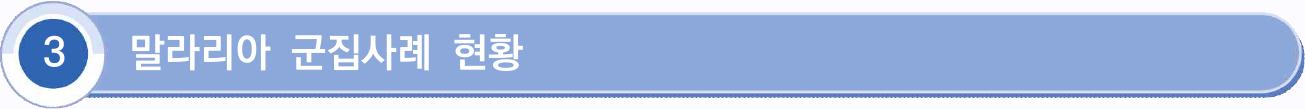

In [35]:
def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'"2. Ch.01-1_LLM_LCEL.ipynb"

    display(HTML(image_html))

plt_img_base64(docs_by_type['images'][1])

In [38]:
print(docs_by_type['texts'][0])
print('--'*20)
print(docs_by_type['texts'][1])

42주차 (10.13.~10.19.)

3 말라리아 군집사례 현황

* 군집사례 : 위험지역 내에서 2명 이상의 환자가 증상 발생 간격이 14일 이내, 환자 거주지 거리가 1Km 이내인 경우

사례건수(환자수) 시·도 시군구 발생(군집사례건수) 4개 시도 46건(114명) 합계 ▸5명 군집(1) : 양천구, 강서구(1) 1건(5명) 서울 ▸2명 군집(5) : 서구(2), 강화군(1), 연수구(1), 중구(1) 인천 5건(10명) ▸6명 군집(1) : 파주시(1) ▸4명 군집(3) : 파주시(2), 김포시(1), ▸3명 군집(6) : 파주시(4), 김포시(1), 일산서구(1) 경기 39건(94명) ▸2명 군집(29) : 파주시(15), 김포시(10), 일산동구(2), 일산서구(1), 연천군(1) ▸5명 군집(1) : 철원군(1) 1건(5명) 강원

그림 6. 군집사례
----------------------------------------
42주차 (10.13.~10.19.) 신분별 발생 현황 - ’24년 전체 말라리아 환자 국내 발생 630명 중 민간인 479명(76.0%), 현역군인 85명(13.5%), 제대군인 66명(10.5%) 순으로 발생 표4 신분별 말라리아 국내발생 현황 (단위: 명(%)) 전년 대비(42주) 2023년 구분 2023년 2024년 (1. 1.∼12. 31.) (1. 1.∼10. 19.) (1. 1.∼10. 21.) 630 (100.0) 663 (100.0) 전체 673 (100.0) 543 (80.7) 민간인 479 (76.0) 533 (80.4) 84 (12.7) 85 (13.5) 현역군인 84 (12.5) 46 ( 6.8) 제대군인 66 (10.5) 46 ( 6.9) * 제대군인 기준: 최근 2년 이내 군 전역자 지역별 발생 현황 - (주소지 기준) 경기 356명(56.5%), 인천 120명(19.0%), 서울 84명(13.3%), 강원 25명(4.0%), 대구 10명 (1.6%),
